# Cleaning the Weekly Rental Data

In [309]:
import pandas as pd
import os, re

In [310]:
pd.set_option("display.max_rows", None)  # Show all rows, default is 10
pd.set_option("display.max_columns", None)  # Show all columns, default is 20

## Download Data

### Scraped Domain Data

In [311]:
# set download path
data_path = "../data/raw/domain/"

# list csv files, make sure they match
csv_files = [file for file in os.listdir(data_path) if re.match(r'rental_listings_\d{4}_\d{2}.csv', file)]

In [312]:
# list of dataframes 
df_list = []

# read each file, extract year and month from filename, add as columns
for file in csv_files:
    match = re.search(r'rental_listings_(\d{4})_(\d{2}).csv', file)
    if match:
        year = match.group(1)
        quarter = match.group(2)
        df = pd.read_csv(os.path.join(data_path, file))
        df['year'] = year
        df['quarter'] = quarter
        df_list.append(df)

# concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

In [313]:
print(df.iloc[-1])

property_id                                                   17537987.0
url                           /5-40-sandwych-wentworth-nsw-2648-17537987
rental_price                                               $320 per week
bedrooms                                                             2.0
bathrooms                                                            1.0
car_spaces                                                           1.0
property_type                                    Apartment / Unit / Flat
land_area                                                            0.0
property_features                                             2, ,1, ,1,
suburb                                                         WENTWORTH
postcode                                                            2648
scraped_date                                         2025-04-25 21:10:55
wayback_url            https://web.archive.org/web/20250425211055/htt...
wayback_time                                       

In [314]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 31268, Columns: 52


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

### Suburb CSV

In [316]:
# import the suburb csv as a new dataframe
suburb_df = pd.read_csv("../data/geo/vic_suburbs_postcodes.csv")

In [317]:
# lowercase suburb names for both dataframes to ensure consistency
suburb_df['suburb'] = suburb_df['suburb'].str.lower()
df['suburb'] = df['suburb'].str.lower()

In [318]:
print(f"Rows: {suburb_df.shape[0]}, Columns: {suburb_df.shape[1]}")

Rows: 3186, Columns: 2


In [319]:
df['suburb'].nunique(), df['postcode'].nunique()

(1031, 512)

We clearly have to check the suburbs for duplicates, typos, and possible records outside of Victoria

# Column Standardisation

Let's begin by standardising the columns

This will include: 

- checking for inconsistent column names across files
- rename columns to snake_case
- drop irrelevant columns

In [320]:
# standardise column names to snake_case
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

In [322]:
# only keep relevant columns
relevant_columns = [
    'rental_price', 'bedrooms', 'bathrooms', 'car_spaces',
    'property_type', 'land_area', 'property_features', 
    'suburb', 'postcode', 'year', 'quarter',
    'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus',
    'agency_name', 'agent_name', 'appointment_only', 'avg_days_on_market',
    'description', 'family_percentage', 'features_list', 
    'first_listed_date', 'full_address', 'last_sold_date',
    'latitude', 'longitude', 'listing_status', 'long_term_resident', 
    'median_rent_price', 'median_sold_price', 'number_sold',
    'renter_percentage', 'schools', 'single_percentage',
    'state_abbreviation', 'structured_features', 'unit_number', 'updated_date',
    'url'
]

df = df[relevant_columns]

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rental_price         31265 non-null  object 
 1   bedrooms             30944 non-null  object 
 2   bathrooms            17067 non-null  float64
 3   car_spaces           29156 non-null  float64
 4   property_type        31265 non-null  object 
 5   land_area            17122 non-null  float64
 6   property_features    31240 non-null  object 
 7   suburb               31268 non-null  object 
 8   postcode             31268 non-null  int64  
 9   year                 31268 non-null  object 
 10  quarter              31268 non-null  object 
 11  age_0_to_19          14143 non-null  float64
 12  age_20_to_39         14143 non-null  float64
 13  age_40_to_59         14143 non-null  float64
 14  age_60_plus          14143 non-null  float64
 15  agency_name          14143 non-null 

In [324]:
df['state_abbreviation'].value_counts()

state_abbreviation
vic    14143
Name: count, dtype: int64

## Record Standardisation
Let's standardise our data in the following ways:
- stripping leading/trailing spaces
- lowercasing
- collapse multiple spaces
- remove punctuation 
- standardise abbreviations
- validate against controlled vocabularies


In [325]:
# create a udf to preprocess string columns
def preprocess_string_column(col):
    """
    Preprocess a string column by:
    - stripping leading/trailing spaces
    - collapsing multiple spaces
    - removing punctuation (except for hyphens and apostrophes)
    - lowercasing
    """
    if pd.isna(col):
        return col
    # handle non-string entries
    if not isinstance(col, str):
        col = str(col)
    # strip leading/trailing spaces
    col = col.strip()
    # collapse multiple spaces
    col = re.sub(r'\s+', ' ', col)
    # remove punctuation (except for hyphens and apostrophes)
    col = re.sub(r'[^\w\s\'-]', '', col)
    # lowercase
    col = col.lower()
    return col

In [326]:
# apply string preprocessing to columns with type object
string_columns = df.select_dtypes(include=['object']).columns
for col in string_columns:
    df[col] = df[col].apply(preprocess_string_column)

### Suburbs

In [327]:
df['suburb'].nunique(), df['postcode'].nunique()

(1031, 512)

In [328]:
df['suburb'].sort_values().unique()

array(['abbotsford', 'aberfeldie', 'acheron', ..., 'yellingbo', 'yendon',
       'yinnar south'], shape=(1031,), dtype=object)

In [329]:
suburb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   postcode  3186 non-null   int64 
 1   suburb    3186 non-null   object
dtypes: int64(1), object(1)
memory usage: 49.9+ KB


In [335]:
# which entries from suburb_df['suburb'] are not in df['suburb']
suburb_df[~suburb_df['suburb'].isin(df['suburb'])].count()

postcode    2129
suburb      2129
dtype: int64

## Dealing with Missing Values

Let's first inspect the missing values to see if there are any trends

In [253]:
df.isna().sum()

rental_price               0
bedrooms                   0
bathrooms              14201
car_spaces              2112
property_type              0
land_area              14146
property_features          0
suburb                     0
postcode                   0
year                       0
quarter                    0
age_0_to_19            17125
age_20_to_39           17125
age_40_to_59           17125
age_60_plus            17125
agency_name                0
agent_name                 0
appointment_only           0
avg_days_on_market     17126
description                0
family_percentage      17125
features_list              0
first_listed_date          0
full_address               0
last_sold_date             0
latitude               17125
longitude              17125
listing_status             0
long_term_resident     17125
median_rent_price      17126
median_sold_price      17126
number_sold            17125
renter_percentage      17125
schools                    0
single_percent

First of all, having rental_price is essential; drop the records without this value

In [254]:
# drop rows where rental_price is missing
df = df.dropna(subset=['rental_price'])

### Clean and Convert Key Fields

We need to clean and convert columns to be more standardised and easier to analyse

Let's start with the rental_price.



First, let's remove '$' and ',' from the values

In [255]:
# remove '$' and ',' from rental_price 
df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_950/641504744.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)


Convert to lower casing to remove some duplicates

In [256]:
df["rental_price"] = df["rental_price"].str.lower()

There are a number of values in which we do not want

In [257]:
# remove spaces in rental_price
df['rental_price'] = df['rental_price'].str.replace(' ', '')

In [258]:
# keep records which start with a number
df = df[df['rental_price'].str.match(r'^\d')]

In [259]:
print(df['rental_price'].value_counts().sort_values())

rental_price
620wifiand1monthfreerent                        1
570perweekpw                                    1
599pw                                           1
350000                                          1
995pwnegotiable                                 1
265weekly                                       1
1700perweekfullyfurnished                       1
535weekly                                       1
83000pw                                         1
52500pw                                         1
416                                             1
84500perweek                                    1
1085pw4715pcm                                   1
760perweekwifiincluded                          1
950wifiand1monthfreerent                        1
730unlimitedwifiand1monthfreerent               1
450pwavail70425                                 1
670perweek6monthslease                          1
940pw                                           1
340weekfullyfurnished                

In [260]:
# extract numeric value from rental_price (based on the first number found)
df['price_value'] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)

We also need a column to see if the rent is by weekly or monthly payments

In [261]:
freq_keywords = [
    'pw', 'perweek', 'weekly', 'p/w', 'wk', 'p.w.',
    '/wk', '/w', '/week', 'p.w',
    'permonth', 'pm', 'calendar', 'monthly', 'calender',
    'percalendarmonth', 'percalendermonth'
    ]

In [262]:
# Extract frequency keyword after the number
df["price_frequency"] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)+(" + "|".join(freq_keywords) + ")", expand=False)[1]

In [263]:
# Map known patterns to standardized categories
df["price_frequency"] = df["price_frequency"].map({
    "pw": "weekly",
    "p.w.": "weekly",
    "perweek": "weekly",
    "weekly": "weekly",
    "p/w": "weekly",
    "wk": "weekly",
    "p.w": "weekly",
    "/wk": "weekly",
    "/w": "weekly",
    "/week": "weekly",
    "pm": "monthly",
    "permonth": "monthly",
    "calendar": "monthly",
    "calender": "monthly",
    "monthly": "monthly",
    "percalendarmonth": "monthly",
    "percalendermonth": "monthly"
})

In [264]:
# If price is purely numeric (digits and full stops), assume weekly
numeric_mask = df["rental_price"].str.match(r"^[\d\.]+$")
df.loc[numeric_mask & df["price_frequency"].isna(), "price_frequency"] = "weekly"

# Assign 'unknown' to unmatched entries
df["price_frequency"] = df["price_frequency"].fillna("unknown")

# Convert to categorical type
df["price_frequency"] = pd.Categorical(df["price_frequency"], categories=["weekly", "monthly", "unknown"])

In [265]:
df['price_frequency'].value_counts()

price_frequency
weekly     30497
unknown      116
monthly       77
Name: count, dtype: int64

In [266]:
df[df['price_frequency'] == 'unknown']['rental_price'].value_counts().sort_values()

rental_price
395-perweek                            1
460-fullyfurnished                     1
730wavailablenow                       1
1weekrentonowner                       1
104873pcm                              1
600onhold                              1
250pernight-4people                    1
50perhour                              1
3701608pcm                             1
530fullyfurnished                      1
620fullyfurnished                      1
500-fullyfurnished                     1
780-fullyfurnished                     1
450w                                   1
350-fullyfurnished                     1
435to450                               1
650aweekgardeningwifiincluded          1
520weekavailablenow                    1
1380week                               1
950week                                1
650perwek                              1
500wfurnished                          1
1100-furnishedpw                       1
430week1864pcmwaterbillsincluded       1
470

In [267]:
# drop unknown price_frequency
df = df[df['price_frequency'] != 'unknown']

Now that we have a column for the actual price and a column for frequency, let's now calculate the weekly price and replace the rental price with that

In [268]:
# Create weekly_rent based on price_frequency
df["weekly_rent"] = df.apply(
    lambda row: row["price_value"] if row["price_frequency"] == "weekly"
    else row["price_value"] / 4 if row["price_frequency"] == "monthly"
    else None,
    axis=1
)

# Drop original columns
df = df.drop(columns=["rental_price", "price_value", "price_frequency"])


In [269]:
df["weekly_rent"].describe()

count    3.057400e+04
mean     6.947589e+03
std      5.520807e+04
min      1.800000e+01
25%      4.700000e+02
50%      5.650000e+02
75%      7.300000e+02
max      5.302303e+06
Name: weekly_rent, dtype: float64

Let's first deal with the outliers using IQR

In [270]:
import numpy as np
import math as m

# Removing the outliers
def removeOutliers(dataframe, columns):
    """
    Detects and treats outliers using IQR for multiple variables in a DataFrame.
    :param dataframe: The input DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param n: number of records in the dataframe
    :param factor: The IQR factor to use for detecting outliers
    :return: The processed DataFrame with outliers treated
    """

    # calculate the factor based on the number of records
    factor = m.sqrt(np.log(len(dataframe))) - 0.5

    # iterate through each column to treat outliers
    for col in columns:
        # calculate Q1, Q3, and IQR
        Q3 = np.quantile(dataframe[col], 0.75)
        Q1 = np.quantile(dataframe[col], 0.25)
        IQR = Q3 - Q1

        print("IQR value for column %s is: %s" % (col, IQR))

        # determine the lower and upper range for outliers
        lower_range = Q1 - factor * IQR
        upper_range = Q3 + factor * IQR
        
        # filter dataframe to keep only rows within the IQR range
        dataframe = dataframe[(dataframe[col] >= lower_range) & (dataframe[col] <= upper_range)]
        print("After treating outliers, shape of data is: ", dataframe.shape)
    
    return dataframe

In [271]:
df = removeOutliers(df, ['weekly_rent'])

IQR value for column weekly_rent is: 260.0
After treating outliers, shape of data is:  (27198, 40)


Text(0.5, 1.0, 'Distribution of Weekly Rent Prices')

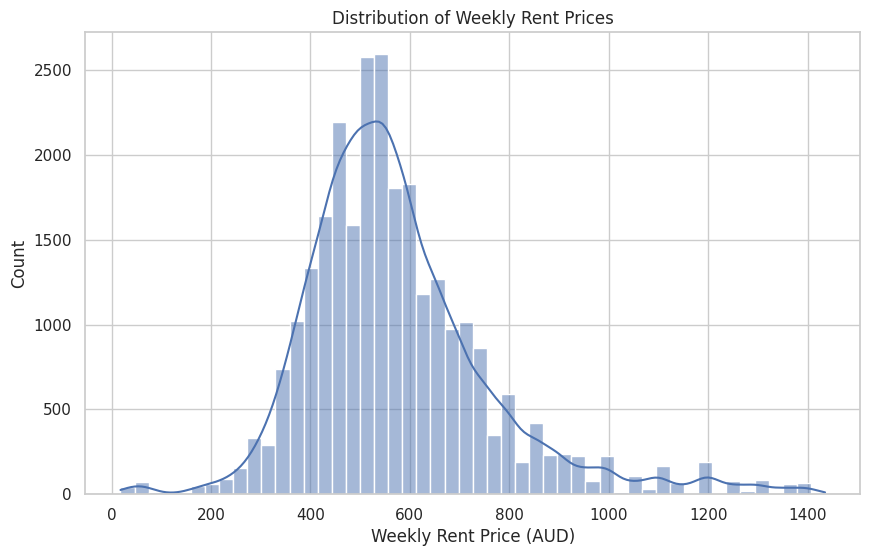

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["weekly_rent"], bins=50, kde=True)

# Add labels and title
plt.xlabel("Weekly Rent Price (AUD)")
plt.ylabel("Count")
plt.title("Distribution of Weekly Rent Prices")

## Cleaning Property Features

In order to answer question 2: Forecasting Rent Growth for suburbs, we need to match our scraped data's categories with provided ones from the ABS website.

The ABS dataset is aggregated by number of bedrooms and property type(1-3 for flats and 1-4 for houses), as well as a separate sheet for the grand total median over suburbs.

We will match that formatting with our scraped data by creating a new dataframe with each suburb as a record, and type of property + number of bedrooms for its columns. Each entry will be the median price of that combination.

### Number of Bedrooms

In [273]:
# find records where 'bedrooms' is missing and 'property_features' doesn't have digits
missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]

# drop rows where bedrooms is missing and 'property_features' doesn't have digits
df = df.drop(missing_bedrooms_features.index)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_950/3890117457.py:2: SyntaxWarning: invalid escape sequence '\d'
  missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]


In [274]:
# drop rows where property_features that do not start with a digit and bedrooms is missing
df_no_digit = df[df['property_features'].str.match(r'^\D', na=False)]
df_no_digit = df_no_digit[df_no_digit['bedrooms'].isnull()]
df = df.drop(df_no_digit.index)

In [275]:
# see if 'bedrooms' matches the first number in 'property_features'
bedroom_pattern = r'\b(\d+),'
df['extracted_bedrooms'] = df['property_features'].str.extract(bedroom_pattern, flags=re.IGNORECASE)[0].astype(float)

# remove records where 'bedrooms' is missing and 'extracted_bedrooms' is also missing
df = df[~(df['bedrooms'].isnull() & df['extracted_bedrooms'].isnull())]

# remove records where 'extracted_bedrooms' is missing
# all these records are acreage or land
df = df[~df['extracted_bedrooms'].isnull()]

In [276]:
# convert 'extracted_bedrooms' to int
df['extracted_bedrooms'] = df['extracted_bedrooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)

In [277]:
# how many records have mismatched bedrooms and extracted_bedrooms
df[df['bedrooms'] != df['extracted_bedrooms']].shape[0]

0

In [278]:
# fill missing bedrooms with extracted_bedrooms
df['bedrooms'].fillna(df['extracted_bedrooms'], inplace=True)

/tmp/ipykernel_950/1743008181.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bedrooms'].fillna(df['extracted_bedrooms'], inplace=True)


In [279]:
# how many records with missing bedrooms now
df['bedrooms'].isnull().sum()

np.int64(0)

In [280]:
# drop 'extracted_bedrooms' column
df = df.drop(columns=['extracted_bedrooms'])

### Property Type


Let's begin by seeing what property types we are given

In [281]:
df['property_type'].value_counts()

Series([], Name: count, dtype: int64)

In [282]:
df['property_type'].isnull().sum()

np.int64(0)

We need to match non house or flat properties to either house or flat

We also need to drop property types which are not 'renter-friendly', or fall out of the two categories' range

The following will be mapped to **House**
- House
- Townhouse
- Villa
- New House & Land
- Semi-Detached
- Terrace
- Duplex

The following will be mapped to **Flat**
- Apartment / Unit / Flat
- Studio
- New Apartments / Off the Plan
- Penthouse

The following will be dropped
- Vacant Land
- Carspace
- Block of Units
- Acreage / Semi-rural
- Rural

Let's begin with cleaning property_type

In [283]:
# convert 'property_type' to lowercase and strip spaces
df['property_type'] = df['property_type'].str.lower()

In [284]:
# create a mapping dictionary
property_type_mapping = {
    "house": ["house", "new house & land", "townhouse", "villa", "semi-detached", "terrace", "duplex", ],
    "flat": ["apartment / unit / flat", "studio", "new apartments / off the plan", "penthouse"],
    "other": ["vacant land", "carspace", "block of units", "acreage / semi-rural", "rural"]
}

In [285]:
# create a new column 'house_flat_other' based on the mapping
df["house_flat_other"] = df["property_type"].apply(
    lambda x: next((key for key, values in property_type_mapping.items() if x in values), "unknown")
)

In [286]:
df['house_flat_other'].value_counts()

Series([], Name: count, dtype: int64)

### Combine and Create New Dataframe

We now want to create and save a new dataframe for each bedroom and property type combo.

Within each csv:
- records will be suburb
- columns will be year and quarter in chronological order
- value will be the median rent

We will do this using pivoted median aggregation

In [287]:
# first convert 'quarter' to numeric
df['quarter'] = pd.to_numeric(df['quarter'], errors='coerce')

# turn 'quarter' into 1, 2, 3, 4
df['quarter'] = ((df['quarter'] - 1) // 3 + 1).astype(int)

In [288]:
import pandas as pd

# Step 1: Create 'bedroom_type' and 'year_quarter' columns
df["bedroom_type"] = df["bedrooms"].astype(str) + " bedroom " + df["house_flat_other"]
df["year_quarter"] = df["year"].astype(str) + "_Q" + (df["quarter"]).astype(str)

# Step 2: Loop through each bedroom_type
for btype in df["bedroom_type"].unique():
    subset = df[df["bedroom_type"] == btype]

    # Step 3: Group and aggregate median rent
    grouped = subset.groupby(["suburb", "year_quarter"])["weekly_rent"].median().reset_index()

    # Step 4: Pivot to wide format
    pivoted = grouped.pivot(index="suburb", columns="year_quarter", values="weekly_rent")

    # Step 5: Save to CSV
    os.makedirs("../data/curated/rent_growth/", exist_ok=True)
    filepath = os.path.join("../data/curated/rent_growth/", f"{btype}.csv")
    pivoted.to_csv(filepath)


# NOTE TO US!

Continue preprocessing here!

Let's have a look at listing status as well, as if they are active, it suggests that the price may not be desirable, therefore the property may not be rented out at this price.

In [289]:
# what values are in 'listing_status'?
df['listing_status'].value_counts()

Series([], Name: count, dtype: int64)